In [175]:
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np 
import pandas as pd
import shutil
import os
import cv2
import os
import json

### Российский набор данных

In [193]:
label_map = pd.read_json('archive\\label_map.json', typ='series')
label_map.head()

21     1
123    2
117    3
324    4
821    5
dtype: int64

In [24]:
train_anno = pd.read_json('archive\\train_anno.json', typ='series')
train_anno.head()

images         [{'id': 0, 'width': 1280, 'height': 720, 'file...
annotations    [{'id': 0, 'image_id': 0, 'category_id': 1, 'a...
categories     [{'id': 1, 'name': '2_1'}, {'id': 2, 'name': '...
dtype: object

In [25]:
train_anno_reduced = pd.read_json('archive\\train_anno_reduced.json', typ='series')
train_anno_reduced.head()

images         [{'id': 51, 'width': 1280, 'height': 720, 'fil...
annotations    [{'id': 31193, 'image_id': 18983, 'category_id...
categories     [{'id': 1, 'name': '2_1'}, {'id': 2, 'name': '...
dtype: object

In [26]:
val_anno = pd.read_json('archive\\val_anno.json', typ='series')
val_anno.head()

images         [{'id': 22978, 'width': 1280, 'height': 720, '...
annotations    [{'id': 37471, 'image_id': 22978, 'category_id...
categories     [{'id': 1, 'name': '2_1'}, {'id': 2, 'name': '...
dtype: object

In [27]:
df_images = pd.DataFrame(train_anno.images)
df_annotations = pd.DataFrame(train_anno.annotations)
df_categories = pd.DataFrame(train_anno.categories)

In [28]:
df_images.head()

,id,width,height,file_name
0,0,1280,720,rtsd-frames/autosave01_02_2012_09_13_33.jpg
1,1,1280,720,rtsd-frames/autosave01_02_2012_09_13_34.jpg
2,2,1280,720,rtsd-frames/autosave01_02_2012_09_13_35.jpg
3,3,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
4,4,1280,720,rtsd-frames/autosave01_02_2012_09_13_37.jpg


In [29]:
df_annotations.head()

,id,image_id,category_id,area,bbox,iscrowd
0,0,0,1,324,"[649, 376, 18, 18]",0
1,1,1,1,420,"[671, 356, 20, 21]",0
2,2,2,1,702,"[711, 332, 27, 26]",0
3,3,3,1,1332,"[764, 290, 37, 36]",0
4,4,3,2,289,"[684, 384, 17, 17]",0


In [203]:
df_annotations.category_id.nunique()

155

In [30]:
df_categories.head()

,id,name
0,1,2_1
1,2,1_23
2,3,1_17
3,4,3_24
4,5,8_2_1


In [92]:
cat_mapping = dict(zip(df_categories['id'], df_categories['name']))

In [31]:
df_annotations.image_id.nunique()

54188

In [32]:
df_annotations.category_id.value_counts()/df_annotations.shape[0]*100

category_id
7      23.192519
1      10.500356
8       4.950153
43      4.716625
4       3.938550
         ...    
155     0.003142
59      0.002094
123     0.002094
141     0.001047
76      0.001047
Name: count, Length: 155, dtype: float64

<Axes: ylabel='category_id'>

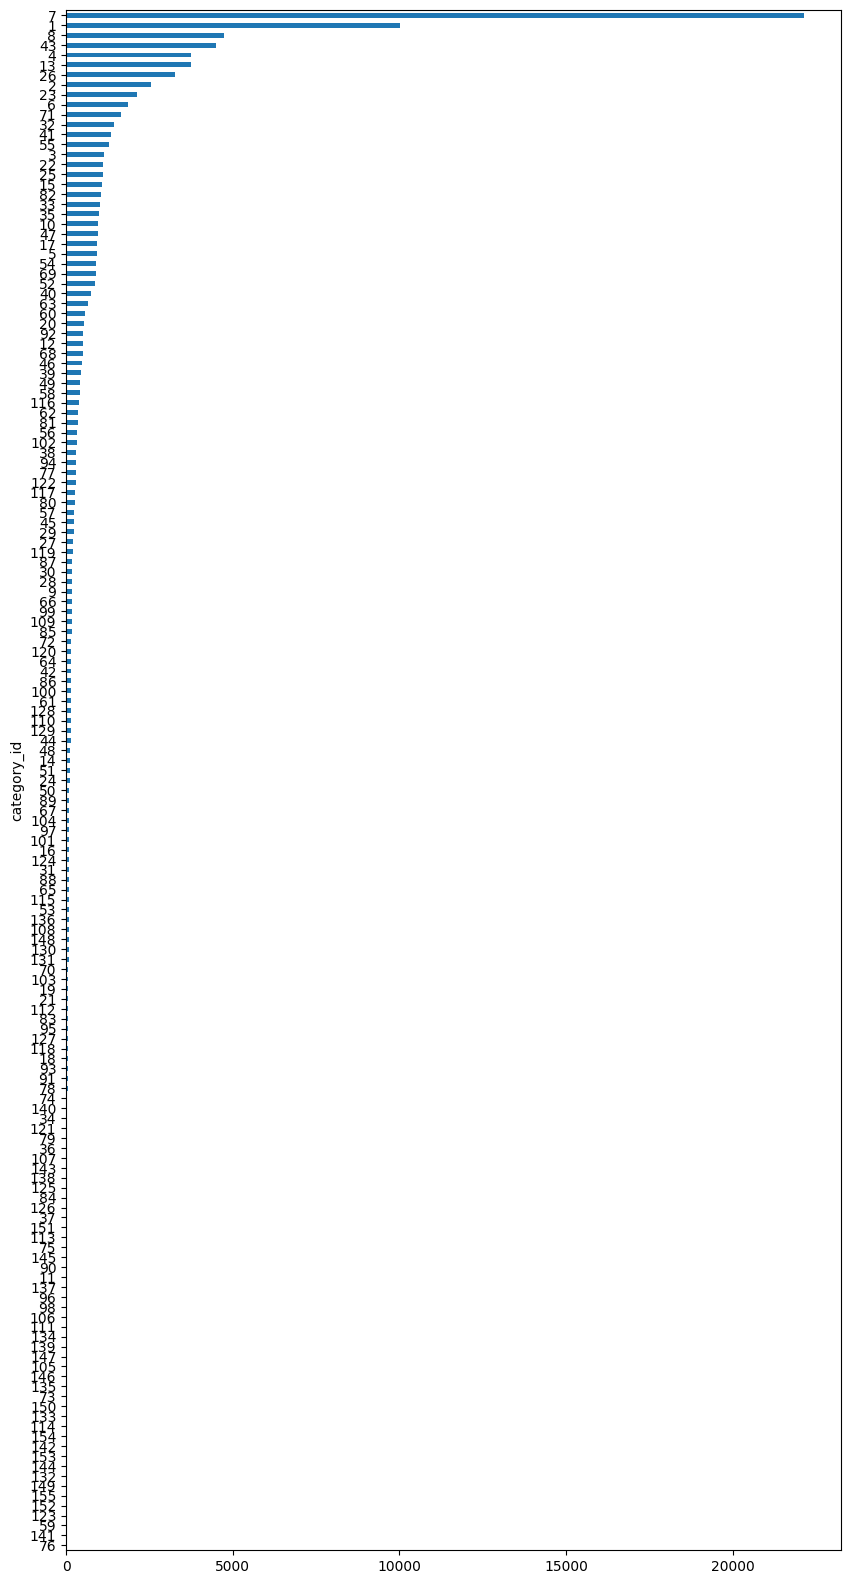

In [49]:
plt.figure(figsize=(10,20))

df_annotations.category_id.value_counts().sort_values().plot(kind = 'barh')

In [74]:
def show_image_with_annotations(image_id):
    image_data = df_images[df_images['id'] == image_id].iloc[0]
    annotations = df_annotations[df_annotations['image_id'] == image_id]
    print(annotations)
    image_path = os.path.join("archive/rtsd-frames", image_data['file_name'])
    image = cv2.imread(image_path)

    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for _, annotation in annotations.iterrows():
        bbox = annotation['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

   id  image_id  category_id  area                bbox  iscrowd
5   5         4            1  3192  [876, 200, 56, 57]        0
6   6         4            2   462  [705, 377, 22, 21]        0


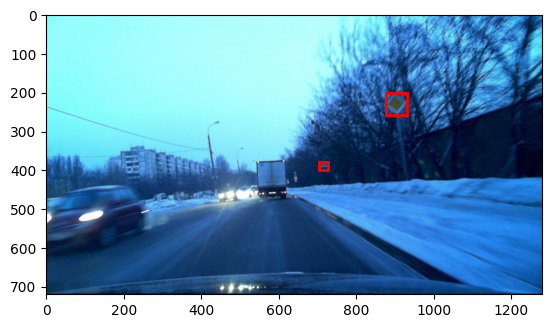

In [75]:
show_image_with_annotations(4)

Но для YOLO V8 его необхдоимо привести в должный формат:
- Создать папку labels с тексовым описанием каждой картинки
- Для этого описания надо bbox преобразовать

In [176]:
images_folder = "rtsd-frames"
output_folder = ["train", "valid", "test"]
output_subfolders = ["images", "labels"]

train_data, test_data = train_test_split(train_anno.images, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

for folder in output_folder:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)
    
# Функция для преобразования bbox в формат YOLO
def convert_bbox(bbox, width, height):
    x_center = (bbox[0] + bbox[2] / 2) / width
    y_center = (bbox[1] + bbox[3] / 2) / height
    w = bbox[2] / width
    h = bbox[3] / height
    return x_center, y_center, w, h

In [177]:
for data, folder in zip([train_data, valid_data, test_data], output_folder):
    for image_info in tqdm(data):
        
        image_id = image_info["id"]
        file_name = image_info["file_name"].split('/')[-1]
        annotations = df_annotations[df_annotations.image_id==image_id].to_dict('records')
        labels_path = f'C:/Users/User/Documents/Projects/itmo_deep_learning/archive/{folder}/labels/{file_name}.txt'

        with open(labels_path, "w") as label_file:
            for annotation in annotations:
                category_id = annotation["category_id"]
                cls = cat_mapping[category_id]
                bbox = convert_bbox(annotation["bbox"], image_info["width"], image_info["height"])
                label_file.write(f"{cls} {' '.join(map(str, bbox))}\n")

        image_path_src = r'C:/Users/User/Documents/Projects/itmo_deep_learning/archive/rtsd-frames/rtsd-frames/'+file_name
        image_path_dst = '/'.join(['C:/Users/User/Documents/Projects/itmo_deep_learning/archive', folder, 'images',file_name])
        shutil.copy(image_path_src, image_path_dst)

100%|██████████| 10838/10838 [00:23<00:00, 452.43it/s]


### Европейский набор данных

In [ ]:
# Здесь должен быть анализ данных

In [ ]:
# for i in df_categories.name.to_list():
#     print('-',i)

### Китайский набор данных

In [ ]:
# Здесь должен быть анализ данных

### Обучение ru dataset

In [180]:
from ultralytics import YOLO
import torch

In [181]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [201]:
model = YOLO('yolov8n.pt')

model.to('cuda')

results = model.train(
   data='data_ru.yaml',
   imgsz=640,
   epochs=100,
   batch=16,
   name='yolov8n_v8_50e' 
)

New https://pypi.org/project/ultralytics/8.0.212 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data_ru.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=yolov8n_v8_50e4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras

zero-size array to reduction operation maximum which has no identity


Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8n_v8_50e4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100      3.44G          0      20.94          0          0        640: 100%|██████████| 2439/2439 [02:49<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:07<00:00, 18.33it/s]


IndexError: list index out of range

In [ ]:
#Какой-то косяк в формате

### Обучение eudataset

In [11]:
from ultralytics import YOLO
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


В data.yaml европейский набор данных, т.к. есть необходимый формат для yolo v8
Перед обучением изменил пути в data.yaml

In [3]:
model = YOLO('yolov8n.pt')

model.to('cuda')

results = model.train(
   data='data_eu.yaml',
   imgsz=640,
   epochs=100,
   batch=16,
   name='yolov8n_v8_50e' 
)

engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4, nms=False, l

      5/100      2.76G     0.2789      3.287     0.9915         28        640: 100%|██████████| 95/95 [00:07<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.69it/s]
                   all        558        751      0.418     0.0354     0.0261     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/100      2.77G     0.2719      3.014     0.9802         31        640: 100%|██████████| 95/95 [00:07<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.72it/s]
                   all        558        751      0.436     0.0369     0.0348     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/100      2.77G     0.2507       2.78     0.9644         31        640: 100%|██████████| 95/95 [00:07<00:00, 12.82it/s]
       

     24/100      2.77G     0.1591       1.42     0.9225         22        640: 100%|██████████| 95/95 [00:07<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.26it/s]
                   all        558        751      0.379      0.113     0.0926      0.057

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/100      2.76G     0.1594       1.39     0.9174         28        640: 100%|██████████| 95/95 [00:07<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.12it/s]
                   all        558        751       0.36      0.104     0.0953     0.0597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     26/100      2.77G     0.1607      1.376     0.9201         31        640: 100%|██████████| 95/95 [00:07<00:00, 12.70it/s]
       

     43/100      2.77G     0.1317      1.118     0.9138         26        640: 100%|██████████| 95/95 [00:07<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.96it/s]
                   all        558        751      0.377      0.127      0.109     0.0681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/100      2.77G      0.138      1.154     0.9063         26        640: 100%|██████████| 95/95 [00:07<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.30it/s]
                   all        558        751      0.354       0.13      0.105     0.0659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/100      2.76G     0.1312      1.124     0.9049         29        640: 100%|██████████| 95/95 [00:07<00:00, 12.66it/s]
       

     62/100      2.77G     0.1271      1.016     0.9078         33        640: 100%|██████████| 95/95 [00:07<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.08it/s]
                   all        558        751      0.387      0.129      0.124     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/100      2.77G     0.1258      1.021     0.9068         27        640: 100%|██████████| 95/95 [00:07<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.99it/s]
                   all        558        751      0.349      0.139      0.122     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/100      2.77G     0.1167       1.01     0.9002         36        640: 100%|██████████| 95/95 [00:07<00:00, 12.72it/s]
       

     81/100      2.76G     0.1145     0.9436     0.9001         25        640: 100%|██████████| 95/95 [00:07<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.27it/s]
                   all        558        751      0.345      0.139      0.128     0.0788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/100      2.77G      0.108     0.9447     0.8979         28        640: 100%|██████████| 95/95 [00:07<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.11it/s]
                   all        558        751      0.386      0.147      0.131     0.0798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/100      2.77G     0.1128     0.9516     0.8993         33        640: 100%|██████████| 95/95 [00:07<00:00, 12.66it/s]
       

    100/100      2.77G     0.1151     0.5609     0.8925         11        640: 100%|██████████| 95/95 [00:06<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 10.76it/s]
                   all        558        751      0.403      0.136      0.129     0.0803

100 epochs completed in 0.271 hours.
Optimizer stripped from runs\detect\yolov8n_v8_50e2\weights\last.pt, 6.9MB
Optimizer stripped from runs\detect\yolov8n_v8_50e2\weights\best.pt, 6.9MB

Validating runs\detect\yolov8n_v8_50e2\weights\best.pt...
Ultralytics YOLOv8.0.211  Python-3.8.18 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
Model summary (fused): 168 layers, 3346481 parameters, 0 gradients, 9.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.67it/s]
                   all        558        751      0.381      0.149      0.132     0.082

### Предсказание на картинках

In [21]:
from ultralytics import YOLO
from PIL import Image

In [22]:
model = YOLO('yolov8n.pt')

In [23]:
#Картинка из интернета. Россия
results = model('results//example_image_1.jpg')

for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    #im.show()
    im.save('results//example_image_1_predict_base_model.jpg') 


image 1/1 C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_image_1.jpg: 480x640 (no detections), 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


In [24]:
#Картинка из теста. Не Россия
results = model('results//example_image_2.jpg')

for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    #im.show()
    im.save('results//example_image_2_predict_base_model.jpg')


image 1/1 C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_image_2.jpg: 384x640 2 cars, 1 truck, 1 stop sign, 38.5ms
Speed: 2.0ms preprocess, 38.5ms inference, 10.1ms postprocess per image at shape (1, 3, 384, 640)


In [25]:
model = YOLO('runs\\detect\\yolov8n_v8_50e2\\weights\\best.pt')

In [26]:
#Картинка из интернета. Россия
results = model('results//example_image_1.jpg')

for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    #im.show()
    im.save('results//example_image_1_predict_train_model.jpg') 


image 1/1 C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_image_1.jpg: 480x640 2 Childrens, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


In [27]:
#Картинка из теста. Не Россия
results = model('results//example_image_2.jpg')

for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    #im.show()
    im.save('results//example_image_2_predict_train_model.jpg')


image 1/1 C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_image_2.jpg: 384x640 1 No right turn, 1 Stop, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


### Предсказание на видео

In [8]:
from matplotlib import animation
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import os

In [9]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    plt.axis('off')
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    plt.close()
    
    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//4)

In [10]:
path_mp1 = 'results\\example_video.mp4'
path_mp2 = 'runs\\detect\\predict\\example_video.mp4'

In [11]:
%%time

!yolo task=detect mode=predict model='runs\\detect\\yolov8n_v8_50e2\\weights\\best.pt' conf=0.2 source={path_mp1}

CPU times: total: 109 ms
Wall time: 2min 3s


C:\Users\User\anaconda3\envs\myenv_py_3_8_dl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\envs\myenv_py_3_8_dl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\User\anaconda3\envs\myenv_py_3_8_dl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
Ultralytics YOLOv8.0.211  Python-3.8.18 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
Model summary (fused): 168 layers, 3346481 parameters, 0 gradients, 9.6 GFLOPs

video 1/1 (1/7069) C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_video.mp4: 384x640 (no detections), 86.1ms
video 1/1 (2/7069) C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_video.mp4: 384x640 (no detections), 3.1ms
video 1/1 (3/7069) C:\Users\User\Documents\Projects\itmo_deep_learning\results\example_video.mp4: 384x640 (no detec

Видео продолжительностью 3:55 и размером 120МБ обрабатывалось 2min 3s

#### Черновики для создания анимации

In [7]:
# def video2frames(video_file=path_mp2, image_dir='img\\', image_file='img_%s.png'):
#     i = 0
#     cap = cv2.VideoCapture(video_file)
#     print(cap.isOpened())
#     while(cap.isOpened()):
#         print('1')
#         flag, frame = cap.read()
#         if flag == False:
#             break
#         cv2.imwrite(image_dir+image_file % str(i).zfill(6), frame) 
#         i += 1
#     cap.release()
    

# video2frames()

# paths0=[]

# for dirname, _, filenames in os.walk('img\\'):
#     for filename in filenames:
#         if filename[-4:]=='.png':
#             paths0+=[(os.path.join(dirname, filename))]
            
# images0=[]

# for i in tqdm(range(len(paths0))):
#     images0+=[cv2.imread(paths0[i])]
    
# anim = create_animation(np.array(images0))

# writervideo = animation.FFMpegWriter(fps=30)
# anim.save('results\\example_video_result.avi', writer=writervideo)

False
